In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
exchange_df = pd.read_csv('../data/crypto_exchange_data_preprocessed.csv')
exchange_df

,text,reddit_score,date,source,exchange,platform,rating,cleaned_text,sentiment,sentiment_score,...,security,coin_listings,performance,entities,keywords,is_duplicate,id,type,parent_id,word_count
0,Not every new coin is a shitcoin: How to spot ...,20345.0,2021-05-11,r/CryptoCurrency,binance,web,NaN,every new coin shitcoin spot real gem inside s...,positive,0.9956,...,0.8553,0.9979,0.6854,"['day ago', 'bsc binance smart', 'max', 'first...","[""coin"", ""new"", ""want"", ""make"", ""time"", ""dont""...",False,0,submission,NaN,724
1,Great post. I have a few questions. \n\n1) How...,12.0,2021-05-11,r/CryptoCurrency,binance,web,NaN,great post question easy get coin listed vetti...,positive,0.1027,...,-0.8316,0.7351,0.0000,"['coin binance regulatory', 'joe', 'new york s...","[""coin"", ""question"", ""post"", ""scam"", ""new"", ""n...",False,1,comment,t3_n9cby0,68
2,> Start trading on the BSC (Binance) Smart Cha...,59.0,2021-05-11,r/CryptoCurrency,binance,web,NaN,start trading bsc binance smart chain reason im,positive,0.4019,...,0.0000,0.0000,0.0000,['bsc binance smart'],"[""reason"", ""trading"", ""im"", ""binance""]",False,2,comment,t3_n9cby0,8
3,"okay so i bought into 3 coins, around $10 tota...",3.0,2021-05-12,r/CryptoCurrency,binance,web,NaN,okay bought coin around total went one two see...,positive,0.7351,...,0.0000,0.7351,0.0000,['one two'],"[""coin"", ""fee"", ""like""]",False,3,comment,t3_n9cby0,23
4,Some great advice. Lots of hidden gems on the ...,3.0,2021-05-11,r/CryptoCurrency,binance,web,NaN,great advice lot hidden gem binance smart chai...,positive,0.4767,...,0.4767,0.0000,0.0000,[],"[""lot"", ""scam"", ""binance""]",False,5,comment,t3_n9cby0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44523,"hello, my bybit account is restricted or banne...",NaN,2022-10-21,trustpilot,bybit,web,1.0,hello bybit account restricted banned month si...,positive,0.5988,...,-0.6705,0.0000,0.0000,"['hello bybit account', 'month']","[""bybit"", ""account"", ""transaction"", ""want"", ""h...",False,49407,trustpilot review,NaN,78
44524,I loved my time trading on this website everyt...,NaN,2022-05-21,trustpilot,bybit,web,5.0,loved time trading website everything ui custo...,positive,0.8779,...,0.0000,0.0000,0.0000,[],"[""good"", ""trading"", ""customer"", ""im"", ""time"", ...",False,49408,trustpilot review,NaN,13
44525,I've Lost more than 900$ for a long order clos...,NaN,2022-10-13,trustpilot,bybit,web,1.0,ive lost long order closed automatically liqui...,positive,0.5175,...,0.0000,0.0000,0.0000,[],"[""order"", ""dont"", ""support"", ""transaction"", ""t...",False,49409,trustpilot review,NaN,32
44526,Scam exchange has scammed me 114$ on p2p and n...,NaN,2022-10-11,trustpilot,bybit,web,1.0,scam exchange scammed pp customer support resp...,negative,-0.2732,...,-0.4588,0.0000,0.0000,"['pp customer', 'hour']","[""hour"", ""scam"", ""got"", ""exchange"", ""time"", ""s...",False,49410,trustpilot review,NaN,42


In [12]:
# Count sentiment distribution
sentiment_counts_ex = exchange_df['sentiment'].value_counts()

# Display basic stats
num_records_ex = len(exchange_df)
num_positive_ex = sentiment_counts_ex.get("positive", 0)
num_negative_ex = sentiment_counts_ex.get("negative", 0)
num_neutral_ex = sentiment_counts_ex.get("neutral", 0)

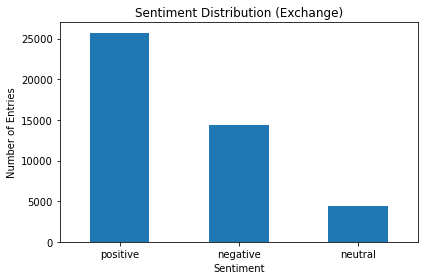

In [13]:
# Plot sentiment distribution
plt.figure(figsize=(6,4))
sentiment_counts_ex.plot(kind='bar', title="Sentiment Distribution (Exchange)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Entries")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# Create a summary DataFrame
sentiment_summary_ex = pd.DataFrame({
    'Sentiment': ['positive', 'negative', 'neutral'],
    'Count': [num_positive_ex, num_negative_ex, num_neutral_ex]
})
sentiment_summary_ex

,Sentiment,Count
0,positive,25710
1,negative,14400
2,neutral,4418


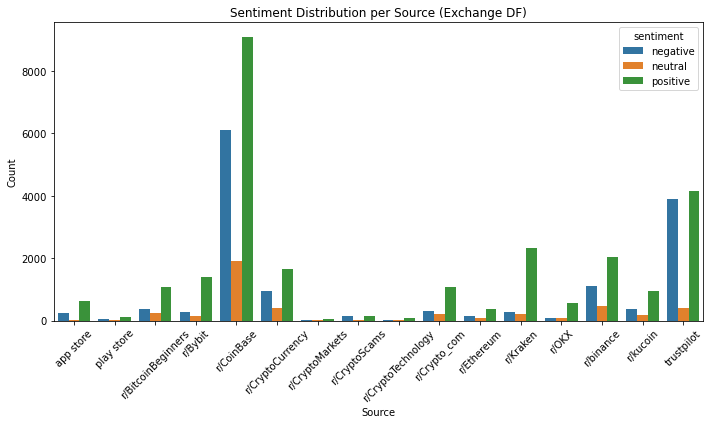

In [19]:
grouped = exchange_df.groupby(['source', 'sentiment']).size().reset_index(name='count')

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='source', y='count', hue='sentiment')

# Add titles and labels
plt.title('Sentiment Distribution per Source (Exchange DF)')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### We only balance positive and negative. We don't reduce the 2 to match neutral but we keep neutral sentiments.

In [20]:
def balance_sentiment_pos_neg(df, label_col='sentiment'):
    # Filter only positive and negative
    pos_neg_df = df[df[label_col].isin(['positive', 'negative'])]
    
    # Find minimum count between them
    min_count = pos_neg_df[label_col].value_counts().min()
    
    # Sample both classes equally
    balanced_pos_neg = (
        pos_neg_df.groupby(label_col)
        .apply(lambda x: x.sample(min_count, random_state=42))
        .reset_index(drop=True)
    )
    
    # Get neutral entries as is (do not balance)
    neutral_df = df[df[label_col] == 'neutral']
    
    # Combine back
    return pd.concat([balanced_pos_neg, neutral_df], ignore_index=True)

In [21]:
# Apply balancing per source
sources = exchange_df['source'].unique()
balanced_list = []

for src in sources:
    source_df = exchange_df[exchange_df['source'] == src]
    
    sentiments_present = set(source_df['sentiment'].unique())
    if 'positive' in sentiments_present and 'negative' in sentiments_present:
        balanced = balance_sentiment_pos_neg(source_df)
        balanced_list.append(balanced)
    else:
        print(f"⚠️ Skipping {src} due to missing positive/negative sentiment")

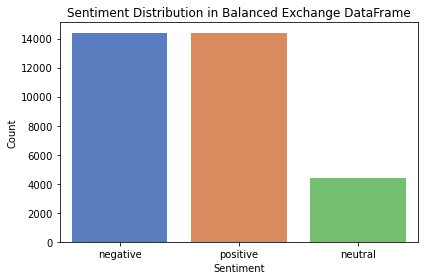

In [22]:
balanced_exchange_df = pd.concat(balanced_list, ignore_index=True)
balanced_sentiment_counts = balanced_exchange_df['sentiment'].value_counts().reset_index()
balanced_sentiment_counts.columns = ['sentiment', 'count']

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=balanced_sentiment_counts, x='sentiment', y='count', palette='muted')
plt.title('Sentiment Distribution in Balanced Exchange DataFrame')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

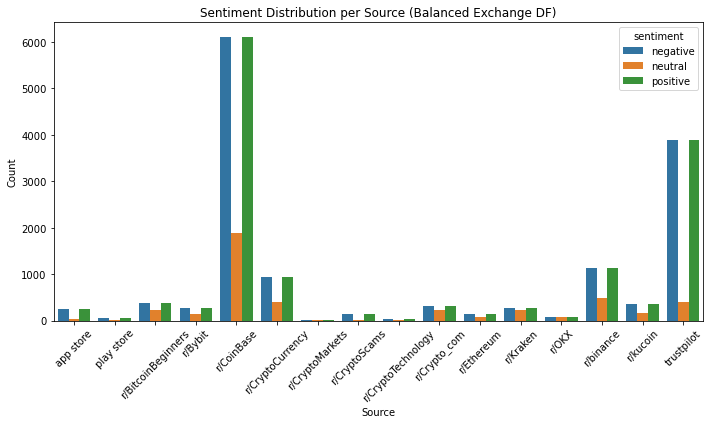

In [23]:
grouped = balanced_exchange_df.groupby(['source', 'sentiment']).size().reset_index(name='count')

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='source', y='count', hue='sentiment')

# Add titles and labels
plt.title('Sentiment Distribution per Source (Balanced Exchange DF)')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Count sentiment distribution
sentiment_counts_ex = balanced_exchange_df['sentiment'].value_counts()

# Display basic stats
num_records_ex = len(exchange_df)
num_positive_ex = sentiment_counts_ex.get("positive", 0)
num_negative_ex = sentiment_counts_ex.get("negative", 0)
num_neutral_ex = sentiment_counts_ex.get("neutral", 0)

# Create a summary DataFrame
sentiment_summary = pd.DataFrame({
    'Sentiment': ['positive', 'negative', 'neutral'],
    'Count': [num_positive_ex, num_negative_ex, num_neutral_ex]
})
sentiment_summary

,Sentiment,Count
0,positive,14400
1,negative,14400
2,neutral,4418


In [25]:
balanced_exchange_df.to_csv('../data/crypto_exchange_data.csv', index=False)